# Increasing Profits Through Demand Forecasting  

Using Seoul Bike Sharing Demand Data

[https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand#](https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand) 

## Frame the problem and look at the big picture

The goal of this project is to predict the hourly demand of bike rentals. With this information we can have the correct number of bikes available for customers to rent. We can eliminate waste and the cost associated with having too many bikes. Also we make sure we don’t stock out of bikes which helps us claim more revenue.

In [39]:
import pandas as pd 
import numpy as np 
import os
from pathlib import Path, PurePath
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from pandas.plotting import scatter_matrix 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score,cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest,chi2

seed = 2020

folder = Path.cwd()
# print(folder)

## Get the Data

The data comes as a csv file called “SeoulBikeData”. The data set contains a dependent variable (Rented Bike Count) and 13 independent variables.

We read it into a dataframe and do a quick investigation of the data. The data isn’t being read correctly so we need to convert that for the whole dataset.

In [40]:
# Read in data 
file_data = 'SeoulBikeData.csv'

df = pd.read_csv(filepath_or_buffer=file_data
                , encoding = "ISO-8859-1")

# converting Date to a datetime data type
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")                
df_date_range = pd.to_datetime(df['Date'])

print(df.shape)
print(f"\nMin: {df_date_range.min().date()} Max: {df_date_range.max().date()} \n")
print(df.head())

(8760, 14)

Min: 2017-12-01 Max: 2018-11-30 

        Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0 2017-12-01                254     0             -5.2           37   
1 2017-12-01                204     1             -5.5           38   
2 2017-12-01                173     2             -6.0           39   
3 2017-12-01                107     3             -6.2           40   
4 2017-12-01                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.

### 

Before we look at the data anymore, we should split it out our train, validation, and test data sets.

In [41]:
X = df.drop(['Rented Bike Count'], axis='columns')
y = df['Rented Bike Count']

# Create Test Set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

# Create Validation Set 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=seed)

#Check by count 
print(f'X_train\t{X_train.shape}\t{len(X_train)/len(df)}')
print(f'y_train\t{y_train.shape}\t\t{len(y_train)/len(df)}')
print(f'X_val\t{X_val.shape}\t{len(X_val)/len(df)}')
print(f'y_val\t{y_val.shape}\t\t{len(y_val)/len(df)}')
print(f'X_test\t{X_test.shape}\t{len(X_test)/len(df)}')
print(f'y_test\t{y_test.shape}\t\t{len(y_test)/len(df)}\n')

X_train	(5256, 13)	0.6
y_train	(5256,)		0.6
X_val	(1752, 13)	0.2
y_val	(1752,)		0.2
X_test	(1752, 13)	0.2
y_test	(1752,)		0.2



## Exploratory Data Analysis

Get a view of the variables and their data type. Also check for any missing data.

In [42]:
# View the data types and see if there is any missing data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5256 entries, 3354 to 1503
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       5256 non-null   datetime64[ns]
 1   Hour                       5256 non-null   int64         
 2   Temperature(°C)            5256 non-null   float64       
 3   Humidity(%)                5256 non-null   int64         
 4   Wind speed (m/s)           5256 non-null   float64       
 5   Visibility (10m)           5256 non-null   int64         
 6   Dew point temperature(°C)  5256 non-null   float64       
 7   Solar Radiation (MJ/m2)    5256 non-null   float64       
 8   Rainfall(mm)               5256 non-null   float64       
 9   Snowfall (cm)              5256 non-null   float64       
 10  Seasons                    5256 non-null   object        
 11  Holiday                    5256 non-null   object        
 12  Fun

In [43]:
print(X_train.describe())

             Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
count  5256.00000      5256.000000  5256.000000       5256.000000   
mean     11.55156        12.770472    58.251903          1.717580   
std       6.93202        11.903115    20.382762          1.040778   
min       0.00000       -17.500000     0.000000          0.000000   
25%       6.00000         3.200000    42.000000          0.900000   
50%      11.00000        13.700000    57.000000          1.500000   
75%      18.00000        22.400000    74.000000          2.300000   
max      23.00000        39.400000    98.000000          7.300000   

       Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
count       5256.000000                5256.000000              5256.000000   
mean        1437.424087                   3.960198                 0.561417   
std          609.151519                  12.989088                 0.860131   
min           27.000000                 -30.600000            

In [44]:
y_train.describe()

count    5256.000000
mean      707.515221
std       654.781206
min         0.000000
25%       189.000000
50%       497.500000
75%      1070.000000
max      3556.000000
Name: Rented Bike Count, dtype: float64

There are no missing values in any columns. There are 3 columns that will need to be prepared before we do any modeling.

In [45]:
print(X_train[['Seasons','Holiday','Functioning Day']].nunique() )

Seasons            4
Holiday            2
Functioning Day    2
dtype: int64


To gain a better understanding of the data I’ll look at the distribution of each numeric variable. We see the number of bikes rented has a Poisson distribution. Wind speed, Visibility (10m), Solar Radiation, Rainfall and Snowfall have either a floor or a ceiling. Temperature & Humidity are close to a normal distribution.

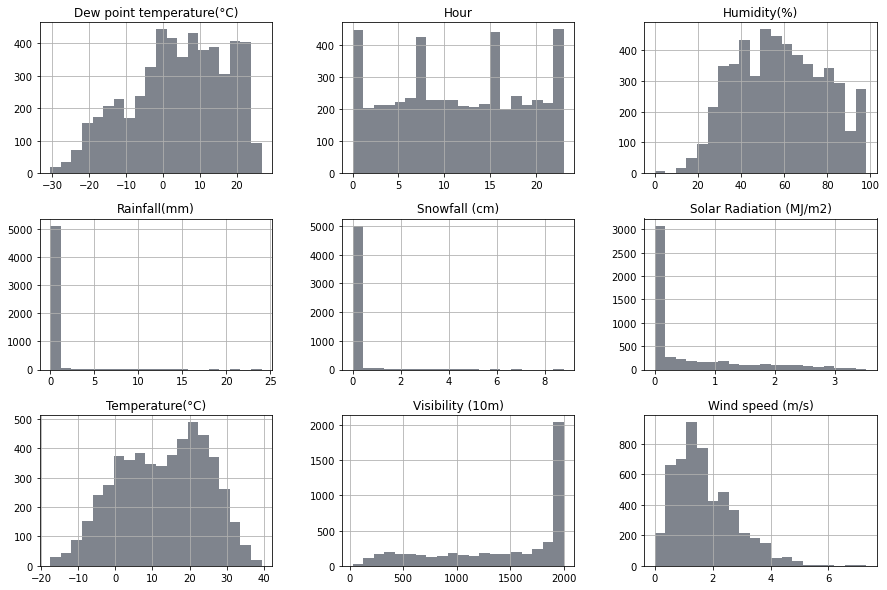

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024806EB9640>,
      dtype=object)

In [46]:
# The Distributions of all the numeric variables
X_train.hist(color='#010a1c', alpha=0.5, figsize=(15,10), bins=20)


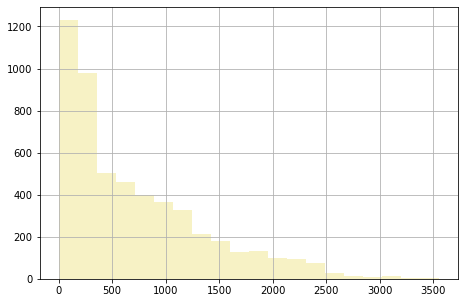

In [47]:
y_train.hist(color='khaki', alpha=0.5, figsize=(7.5,5), bins=20)

I also want to see a correlation matrix of the variables.

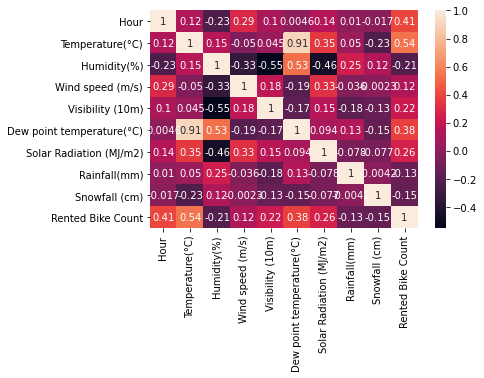

In [48]:
# Correlation Matrix
all_train = pd.concat([X_train, y_train], axis=1)
all_train_marix = all_train.corr()
sns.heatmap(all_train_marix, annot=True)
plt.show()

### **Correlation**

Temperature and Dew point temperature are highly correlated. We want to avoid multicollinearity so we should drop one of the variables.  We want to keep Temperature because it has a higher correlation with Rented Bike Count.

The order of most correlated variable ranked from high to low.

1.  Temperature
2.  Hour
3.  Solar Radiation
4.  Visibility
5.  Humidity
6.  Snowfall
7.  Rainfall
8.  Windspeed

## Prepare the Data

We need to prepare the data for modeling. We will turn Seasons, Holiday, and Functioning Day into dummy variables. We will break down Date into:

1. Year

2. Month

3. Day

4. Week Day

5. Day of Week

We will also drop ‘Dew point temperature’ and scale the variables with a min max scaler.

In [49]:
# Create a funtion for data preperation and cleaning
# ------------------------------------------------------------------------------

def date_prep(DataFrame, Date_Column, Drop_Colum):
    """Takes a date column from a DataFrame and adds Year_Month, Year, Month, Day
    , Week_Day, and Day_of_Week"""
    # DataFrame['Year_Month'] = DataFrame['Date']
    DataFrame['Year'] = DataFrame[Date_Column].dt.year
    DataFrame['Month'] = DataFrame[Date_Column].dt.month
    DataFrame['Day'] = DataFrame[Date_Column].dt.day
    DataFrame['Day_of_Week'] = DataFrame[Date_Column].dt.dayofweek
    DataFrame['Week_Day'] = np.where(DataFrame['Day_of_Week'] >= 5, 1, 0)
    DataFrame.drop([Date_Column],axis=1, inplace=True)

In [50]:
# Prepare the Train Data set
X_train_1 = X_train.copy()
# Break down date into pieces
date_prep(X_train_1,'Date', Drop_Colum = False)
print(X_train_1.shape)
# print(X_train_1.head())

# Create Dummy Variables
df_D1 = pd.get_dummies(X_train_1['Seasons']
                            , prefix='Season'
                            , prefix_sep='_'
                            , drop_first=True)
df_D2 = pd.get_dummies(X_train_1['Holiday']
                            # , prefix='Holiday'
                            , prefix_sep='_'
                            , drop_first=True)
df_D3 = pd.get_dummies(X_train_1['Functioning Day']
                            , prefix='OperatingDay'
                            , prefix_sep='_'
                            , drop_first=True)

X_train_2 = pd.concat([X_train_1, df_D1, df_D2, df_D3], axis=1, sort=False)
X_train_2.drop(['Seasons','Holiday','Functioning Day'],axis=1, inplace=True)

# Drop 'Dew point temperature(°C)'
X_train_2.drop(['Dew point temperature(°C)'],axis=1, inplace=True)



print(X_train_2.shape)
print(X_train_2.head())

min_max_scaler = preprocessing.MinMaxScaler()
X_train_2_minmax = pd.DataFrame(min_max_scaler.fit_transform(X_train_2), columns=X_train_2.columns)
print(X_train_2_minmax.head())

(5256, 17)
(5256, 18)
      Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
3354    18             19.1           31               3.0               958   
323     11             -6.1           38               1.0              1587   
7917    21             10.6           70               2.4              2000   
1681     1             -4.8           44               1.1              1432   
1416     0             -9.3           45               0.7              1976   

      Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Year  Month  Day  \
3354                     0.70           0.0            0.0  2018      4   19   
323                      0.52           0.0            0.0  2017     12   14   
7917                     0.00           0.0            0.0  2018     10   26   
1681                     0.00           0.0            0.0  2018      2    9   
1416                     0.00           0.0            0.0  2018      1   29   

      Day_of_Wee

In [51]:
# Prepare the Valudation Data Set
X_val_1 = X_val.copy()
# Break down date into pieces
date_prep(X_val_1,'Date', Drop_Colum = False)
print(X_val_1.shape)
# print(X_val_1.head())

# Create Dummy Variables
df_D1 = pd.get_dummies(X_val_1['Seasons']
                            , prefix='Season'
                            , prefix_sep='_'
                            , drop_first=True)
df_D2 = pd.get_dummies(X_val_1['Holiday']
                            # , prefix='Holiday'
                            , prefix_sep='_'
                            , drop_first=True)
df_D3 = pd.get_dummies(X_val_1['Functioning Day']
                            , prefix='OperatingDay'
                            , prefix_sep='_'
                            , drop_first=True)

X_val_2 = pd.concat([X_val_1, df_D1, df_D2, df_D3], axis=1, sort=False)
X_val_2.drop(['Seasons','Holiday','Functioning Day'],axis=1, inplace=True)

# Drop 'Dew point temperature(°C)'
X_val_2.drop(['Dew point temperature(°C)'],axis=1, inplace=True)



print(X_val_2.shape)
# print(X_val_2.head())

min_max_scaler = preprocessing.MinMaxScaler()
X_val_2_minmax = pd.DataFrame(min_max_scaler.fit_transform(X_val_2), columns=X_val_2.columns)
print(X_val_2_minmax.head())

(1752, 17)
(1752, 18)
       Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
0  1.000000         0.628623     0.857143          0.160714          1.000000   
1  0.130435         0.661232     0.775510          0.089286          0.957274   
2  0.391304         0.699275     0.653061          0.196429          0.595626   
3  0.391304         0.713768     0.826531          0.410714          0.831638   
4  0.695652         0.943841     0.459184          0.410714          0.728383   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Year     Month  \
0                 0.000000           0.0            0.0   1.0  0.818182   
1                 0.000000           0.0            0.0   1.0  0.727273   
2                 0.327536           0.0            0.0   1.0  0.727273   
3                 0.347826           0.0            0.0   1.0  0.727273   
4                 0.715942           0.0            0.0   1.0  0.545455   

        Day  Day_of_Week  Week_Day  Seas

In [52]:
# Prepare the Test Data Set
X_test_1 = X_test.copy()
# Break down date into pieces
date_prep(X_test_1,'Date', Drop_Colum = False)
print(X_test_1.shape)
# print(X_test_1.head())

# Create Dummy Variables
df_D1 = pd.get_dummies(X_test_1['Seasons']
                            , prefix='Season'
                            , prefix_sep='_'
                            , drop_first=True)
df_D2 = pd.get_dummies(X_test_1['Holiday']
                            # , prefix='Holiday'
                            , prefix_sep='_'
                            , drop_first=True)
df_D3 = pd.get_dummies(X_test_1['Functioning Day']
                            , prefix='OperatingDay'
                            , prefix_sep='_'
                            , drop_first=True)

X_test_2 = pd.concat([X_test_1, df_D1, df_D2, df_D3], axis=1, sort=False)
X_test_2.drop(['Seasons','Holiday','Functioning Day'],axis=1, inplace=True)

# Drop 'Dew point temperature(°C)'
X_test_2.drop(['Dew point temperature(°C)'],axis=1, inplace=True)



print(X_test_2.shape)
# print(X_test_2.head())

min_max_scaler = preprocessing.MinMaxScaler()
X_test_2_minmax = pd.DataFrame(min_max_scaler.fit_transform(X_test_2), columns=X_test_2.columns)
print(X_test_2_minmax.head())

(1752, 17)
(1752, 18)
       Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
0  0.652174         0.434164     0.214286          0.364865          0.948294   
1  0.695652         0.966192     0.357143          0.175676          1.000000   
2  0.260870         0.471530     0.857143          0.094595          0.121510   
3  0.608696         0.674377     0.285714          0.378378          0.581696   
4  0.434783         0.606762     0.459184          0.283784          1.000000   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Year     Month  \
0                 0.630682           0.0            0.0   1.0  0.090909   
1                 0.568182           0.0            0.0   1.0  0.636364   
2                 0.000000           0.0            0.0   1.0  0.181818   
3                 0.781250           0.0            0.0   1.0  0.181818   
4                 0.741477           0.0            0.0   1.0  0.363636   

        Day  Day_of_Week  Week_Day  Seas

In [53]:
print(f'X_train_2_minmax {X_train_2_minmax.shape} ')
print(f'y_train\t{y_train.shape}')
print(f'X_val_2_minmax {X_val_2_minmax.shape}')
print(f'y_val\t{y_val.shape}')
print(f'X_test_2_minmax {X_test_2_minmax.shape}')
print(f'y_test\t{y_test.shape} \n')

X_train_2_minmax (5256, 18) 
y_train	(5256,)
X_val_2_minmax (1752, 18)
y_val	(1752,)
X_test_2_minmax (1752, 18)
y_test	(1752,) 



##  Short List Promising Models

I want to test some models to find which algorithm has the most promise with our data. I will try these algorithms:

1.  Linear Regression
2.  Decision Tree
3.  Random Forest
4.  SVM
5.  XGBoost

I’m going to put the model metrics into a dataframe to simplify the reviewing of the models.  The metrics I’m using are:

1.  Mean Absolute Error (MAE)
2.  Mean Squared Error (MSE)
3.  Root Means Squared Error (RMSE)
4.  R Squared

I will be using Cross Validation with 10 k-folds. I will take an average of the metrics for each model and a standard deviation of RMSE.

In [54]:
#  Get right data frame names
X_train = X_train_2_minmax.copy()
X_val = X_val_2_minmax.copy()
X_test = X_test_2_minmax.copy()

print(f'X_train {X_train.shape} ')
print(f'y_train\t{y_train.shape}')
print(f'X_val {X_val.shape}')
print(f'y_val\t{y_val.shape}')
print(f'X_test {X_test.shape}')
print(f'y_test\t{y_test.shape} \n')

# Create Scored DF
df_score = pd.DataFrame(columns=['Dataset'
                                ,'Model'
                                ,'MAE_Mean'
                                ,'MSE_Mean'
                                ,'RMSE_Mean'
                                ,'RMSE_StandDev'
                                ,'R2'
                                ])

# Create scoring list
scor = ['r2','neg_root_mean_squared_error','neg_mean_absolute_error','neg_mean_squared_error']

X_train (5256, 18) 
y_train	(5256,)
X_val (1752, 18)
y_val	(1752,)
X_test (1752, 18)
y_test	(1752,) 



In [55]:
# Linear Regression
t1000 = dt.datetime.now()

lm_score = cross_validate(estimator=LinearRegression()
                            ,X=X_train
                            ,y=y_train
                            ,scoring=scor
                            ,cv=10)
# Get the scores
df_lm_scores = pd.DataFrame(lm_score)

# Add scores to df
df_score = df_score.append({'Dataset':'Train'
                                ,'Model':'Lin Reg'
                                ,'MAE_Mean':-df_lm_scores['test_neg_mean_absolute_error'].mean()
                                ,'MSE_Mean':-df_lm_scores['test_neg_mean_squared_error'].mean()
                                ,'RMSE_Mean':-df_lm_scores['test_neg_root_mean_squared_error'].mean()
                                ,'RMSE_StandDev':df_lm_scores['test_neg_root_mean_squared_error'].std()
                                ,'R2':df_lm_scores['test_r2'].mean()
                                }
                            , ignore_index=True)

print('\n\nThe block took', dt.datetime.now()-t1000, '(H:MM:SS)')                    



The block took 0:00:00.255316 (H:MM:SS)


In [56]:
# Decision Tree
t1000 = dt.datetime.now()

dt_score = cross_validate(estimator=DecisionTreeRegressor()
                            ,X=X_train
                            ,y=y_train
                            ,scoring=scor
                            ,cv=10)
# Get the scores
df_dt_scores = pd.DataFrame(dt_score)

# Add scores to df
df_score = df_score.append({'Dataset':'Train'
                                ,'Model':'Decision Tree'
                                ,'MAE_Mean':-df_dt_scores['test_neg_mean_absolute_error'].mean()
                                ,'MSE_Mean':-df_dt_scores['test_neg_mean_squared_error'].mean()
                                ,'RMSE_Mean':-df_dt_scores['test_neg_root_mean_squared_error'].mean()
                                ,'RMSE_StandDev':df_dt_scores['test_neg_root_mean_squared_error'].std()
                                ,'R2':df_dt_scores['test_r2'].mean()
                                }
                            , ignore_index=True)

print('\n\nThe block took', dt.datetime.now()-t1000, '(H:MM:SS)')                    



The block took 0:00:00.576459 (H:MM:SS)


In [57]:
# Random Forest 
t1000 = dt.datetime.now()

rf_score = cross_validate(estimator=RandomForestRegressor()
                            ,X=X_train
                            ,y=y_train.values.ravel()
                            ,scoring=scor
                            ,cv=10)
# Get the scores
df_rf_scores = pd.DataFrame(rf_score)

# Add scores to df
df_score = df_score.append({'Dataset':'Train'
                                ,'Model':'Rand Forest'
                                ,'MAE_Mean':-df_rf_scores['test_neg_mean_absolute_error'].mean()
                                ,'MSE_Mean':-df_rf_scores['test_neg_mean_squared_error'].mean()
                                ,'RMSE_Mean':-df_rf_scores['test_neg_root_mean_squared_error'].mean()
                                ,'RMSE_StandDev':df_rf_scores['test_neg_root_mean_squared_error'].std()
                                ,'R2':df_rf_scores['test_r2'].mean()
                                }
                            , ignore_index=True)

print('\n\nThe block took', dt.datetime.now()-t1000, '(H:MM:SS)')   



The block took 0:00:37.932344 (H:MM:SS)


In [58]:
# SVM
t1000 = dt.datetime.now()

svm_score = cross_validate(estimator=SVR() #C=1.0, epsilon=0.2
                            ,X=X_train
                            ,y=y_train.values.ravel()
                            ,scoring=scor
                            ,cv=10)
# Get the scores
df_svm_scores = pd.DataFrame(svm_score)

# Add scores to df
df_score = df_score.append({'Dataset':'Train'
                                ,'Model':'SVM'
                                ,'MAE_Mean':-df_svm_scores['test_neg_mean_absolute_error'].mean()
                                ,'MSE_Mean':-df_svm_scores['test_neg_mean_squared_error'].mean()
                                ,'RMSE_Mean':-df_svm_scores['test_neg_root_mean_squared_error'].mean()
                                ,'RMSE_StandDev':df_svm_scores['test_neg_root_mean_squared_error'].std()
                                ,'R2':df_svm_scores['test_r2'].mean()
                                }
                            , ignore_index=True)

print('\n\nThe block took', dt.datetime.now()-t1000, '(H:MM:SS)')  



The block took 0:00:14.341630 (H:MM:SS)


In [59]:
# XGBoost
t1000 = dt.datetime.now()

xgb_score = cross_validate(estimator=xgb.XGBRegressor() 
                            ,X=X_train
                            ,y=y_train
                            ,scoring=scor
                            ,cv=10)
# Get the scores
df_xgb_scores = pd.DataFrame(xgb_score)

# Add scores to df
df_score = df_score.append({'Dataset':'Train'
                                ,'Model':'XGBoost'
                                ,'MAE_Mean':-df_xgb_scores['test_neg_mean_absolute_error'].mean()
                                ,'MSE_Mean':-df_xgb_scores['test_neg_mean_squared_error'].mean()
                                ,'RMSE_Mean':-df_xgb_scores['test_neg_root_mean_squared_error'].mean()
                                ,'RMSE_StandDev':df_xgb_scores['test_neg_root_mean_squared_error'].std()
                                ,'R2':df_xgb_scores['test_r2'].mean()
                                }
                            , ignore_index=True)

print('\n\nThe block took', dt.datetime.now()-t1000, '(H:MM:SS)')  



The block took 0:00:03.722042 (H:MM:SS)


Looking at the results the Random Forest and XGBoost models were the most accurate.

In [60]:
print(df_score)

  Dataset          Model    MAE_Mean       MSE_Mean   RMSE_Mean  \
0   Train        Lin Reg  327.533141  189853.438355  435.202506   
1   Train  Decision Tree  146.932889   66306.869063  256.820244   
2   Train    Rand Forest  107.449972   33662.981763  182.722040   
3   Train            SVM  411.969877  356116.848303  596.100051   
4   Train        XGBoost  103.088422   27737.381048  166.038309   

   RMSE_StandDev        R2  
0      22.415701  0.556232  
1      19.726777  0.843434  
2      17.500405  0.920709  
3      29.468968  0.168636  
4      13.689454  0.934621  


## Fine-Tune the System

The XGBoost model was the most accurate. I’m going to fine turn the hyperparameter using cross-validation and grid search to find the best set of hyperparameters. I ran many versions of this section. I left some of the code commented out, but I didn’t leave every iteration in the code.

In [61]:
t1000 = dt.datetime.now()

param_grid = [ 
    {'n_estimators': [50, 100, 500, 1000, 1500]
        , 'max_depth': [5,10]}
    # , {'booster': ['gblinear']
    #     , 'n_estimators': [50, 80,100]
    #     , 'max_depth': [10,15]},
     ] 
xgb_reg = xgb.XGBRegressor()
grid_search = GridSearchCV( xgb_reg
                            ,param_grid
                            ,cv = 5
                            ,scoring ='neg_root_mean_squared_error'
                            ,return_train_score = True
                            ,refit='neg_root_mean_squared_error')
grid_search.fit( X_train, y_train.values.ravel())

print(grid_search.best_params_)
print(grid_search.best_estimator_)


print('\n\nThe block took', dt.datetime.now()-t1000, '(H:MM:SS)')

{'max_depth': 10, 'n_estimators': 1000}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


The block took 0:01:42.643398 (H:MM:SS)


In [62]:
# XGBoost
t1000 = dt.datetime.now()

xgb_score = cross_validate(estimator=xgb.XGBRegressor(max_depth=10,n_estimators=1000) 
                            ,X=X_train
                            ,y=y_train
                            ,scoring=scor
                            ,cv=10)
# Get the scores
df_xgb_scores = pd.DataFrame(xgb_score)

# Add scores to df
df_score = df_score.append({'Dataset':'Train'
                                ,'Model':'XGB'
                                ,'MAE_Mean':-df_xgb_scores['test_neg_mean_absolute_error'].mean()
                                ,'MSE_Mean':-df_xgb_scores['test_neg_mean_squared_error'].mean()
                                ,'RMSE_Mean':-df_xgb_scores['test_neg_root_mean_squared_error'].mean()
                                ,'RMSE_StandDev':df_xgb_scores['test_neg_root_mean_squared_error'].std()
                                ,'R2':df_xgb_scores['test_r2'].mean()
                                , 'Hyperparameters ':"max_depth=10,n_estimators=1000"
                                }
                            , ignore_index=True)

print('\n\nThe block took', dt.datetime.now()-t1000, '(H:MM:SS)')



The block took 0:00:34.736043 (H:MM:SS)


In [63]:
print(df_score)

  Dataset          Model    MAE_Mean       MSE_Mean   RMSE_Mean  \
0   Train        Lin Reg  327.533141  189853.438355  435.202506   
1   Train  Decision Tree  146.932889   66306.869063  256.820244   
2   Train    Rand Forest  107.449972   33662.981763  182.722040   
3   Train            SVM  411.969877  356116.848303  596.100051   
4   Train        XGBoost  103.088422   27737.381048  166.038309   
5   Train            XGB   94.742848   27461.917844  165.005591   

   RMSE_StandDev        R2                Hyperparameters   
0      22.415701  0.556232                             NaN  
1      19.726777  0.843434                             NaN  
2      17.500405  0.920709                             NaN  
3      29.468968  0.168636                             NaN  
4      13.689454  0.934621                             NaN  
5      16.161440  0.935259  max_depth=10,n_estimators=1000  


 The best hyperparameters were "max\_depth=10,n\_estimators=1000". I used RMSE as the metric to re-fit for testing.

## Final Test

### **Validate**

The validation results were not at good as the test set which makes sense. I included an actual vs predicted plot. The red line is where the values should be if the predictions were the same as the y values. It looks like 0 - ~ 1300 the values are tighter to the line.

In [64]:
t1000 = dt.datetime.now()

mod_xgb = xgb.XGBRegressor(max_depth=10,n_estimators=1000)

mod_xgb.fit(X_train, y_train)
predictions = mod_xgb.predict(X_val)

val_mae = mean_absolute_error(y_val, predictions)
val_mse = mean_squared_error(y_val, predictions)
val_rmse = np.sqrt(val_mse) 
val_r2 = r2_score(y_val, predictions)

# print(f'Validation MAE: {val_mae:,.4f}')
# print(f'Validation MSE: {val_mse:,.4f}')
# print(f'Validation RMSE: {val_rmse:,.4f}')
# print(f'Validation R2: {val_r2:,.4f}')

# Add scores to df
df_score = df_score.append({'Dataset':'Validate'
                                ,'Model':'XGB'
                                ,'MAE_Mean':val_mae
                                ,'MSE_Mean':val_mse
                                ,'RMSE_Mean':val_rmse
                                ,'RMSE_StandDev': None
                                ,'R2':val_r2
                                , 'Hyperparameters ':"max_depth=10,n_estimators=1000"
                                }
                            , ignore_index=True)

print(df_score[df_score['Dataset']=='Validate'])
print('\n\nThe block took', dt.datetime.now()-t1000, '(H:MM:SS)')

    Dataset Model    MAE_Mean      MSE_Mean   RMSE_Mean RMSE_StandDev  \
6  Validate   XGB  101.062973  28568.056661  169.020876          None   

         R2                Hyperparameters   
6  0.929736  max_depth=10,n_estimators=1000  


The block took 0:00:04.028222 (H:MM:SS)


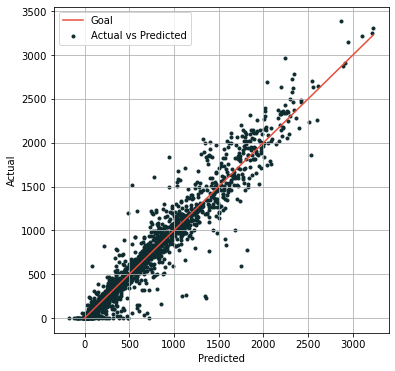

In [65]:
val_pred = pd.DataFrame(predictions,columns=['Rented Bike Count'])

plt.figure(figsize=(6, 6))

plt.grid(b=None, which='major', axis='both')
plt.scatter(val_pred,y_val, c='#0E2B2F', marker='.', label='Actual vs Predicted')
plt.xlabel("Predicted")
plt.ylabel("Actual")
lineStart = 0#val_pred['Rented Bike Count'].min() 
lineEnd = val_pred['Rented Bike Count'].max()  
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = '#E74D39', label='Goal')

plt.legend(loc='upper left')
plt.show()

### **Test**

The test results were better than on the training and validation set. I also included the actual vs values plot. It had similar results as the validation plot.

In [66]:
t1000 = dt.datetime.now()

test_predictions = mod_xgb.predict(X_test)

test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse) 
test_r2 = r2_score(y_test, test_predictions)

# Add scores to df
df_score = df_score.append({'Dataset':'Test'
                                ,'Model':'XGB'
                                ,'MAE_Mean':test_mae
                                ,'MSE_Mean':test_mse
                                ,'RMSE_Mean':test_rmse
                                ,'RMSE_StandDev': None
                                ,'R2':test_r2
                                , 'Hyperparameters ':"max_depth=10,n_estimators=1000"
                                }
                            , ignore_index=True)

print(df_score[df_score['Dataset']=='Test'])
print('\n\nThe block took', dt.datetime.now()-t1000, '(H:MM:SS)')

  Dataset Model   MAE_Mean      MSE_Mean   RMSE_Mean RMSE_StandDev        R2  \
7    Test   XGB  95.851917  25987.424516  161.206155          None  0.932891   

                 Hyperparameters   
7  max_depth=10,n_estimators=1000  


The block took 0:00:00.101727 (H:MM:SS)


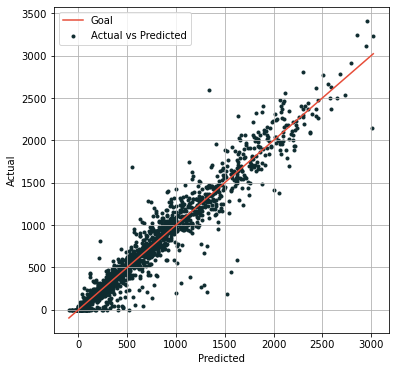

In [67]:
test_pred = pd.DataFrame(test_predictions,columns=['Rented Bike Count'])

plt.figure(figsize=(6, 6))

plt.scatter(test_pred,y_test, c='#0E2B2F', marker='.', label='Actual vs Predicted')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.grid(b=None, which='major', axis='both')
lineStart = 0
lineEnd = test_pred['Rented Bike Count'].max()  
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = '#E74D39', label='Goal')
plt.legend(loc='upper left')
plt.show()

In [68]:
print(df_score)

    Dataset          Model    MAE_Mean       MSE_Mean   RMSE_Mean  \
0     Train        Lin Reg  327.533141  189853.438355  435.202506   
1     Train  Decision Tree  146.932889   66306.869063  256.820244   
2     Train    Rand Forest  107.449972   33662.981763  182.722040   
3     Train            SVM  411.969877  356116.848303  596.100051   
4     Train        XGBoost  103.088422   27737.381048  166.038309   
5     Train            XGB   94.742848   27461.917844  165.005591   
6  Validate            XGB  101.062973   28568.056661  169.020876   
7      Test            XGB   95.851917   25987.424516  161.206155   

  RMSE_StandDev        R2                Hyperparameters   
0       22.4157  0.556232                             NaN  
1       19.7268  0.843434                             NaN  
2       17.5004  0.920709                             NaN  
3        29.469  0.168636                             NaN  
4       13.6895  0.934621                             NaN  
5       16.1614  0